In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
%matplotlib inline

# Loading and exploring the Enron F+E (financial+email) dataset

In [4]:
cd ~/proj/datan/p5_enron/

/home/xery/proj/datan/p5_enron


In [5]:
ls

enron61702insiderpay.pdf            poi_email_addresses.py
final_project_dataset_modified.pkl  poi_id.py*
final_project_dataset.pkl           poi_names.txt
img/                                py2venv-requirements.txt
logreg_roc.eps                      rforest_roc.eps
my_classifier.pkl                   svc_roc.eps
my_dataset.pkl                      tester.py
my_feature_list.pkl                 tester.pyc
p5_enron.ipynb                      tools/


In [6]:
d=pickle.load(open("final_project_dataset.pkl"))

Number of records

In [7]:
len(d)

146

Number of features

In [8]:
len(d.items()[0][1])

21

In [9]:
d.items()[0][1].keys()

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [10]:
df=pd.DataFrame.from_dict(d, orient='index', dtype=np.float)

In [11]:
df.dtypes

salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
exercised_stock_options      float64
bonus                        float64
restricted_stock             float64
shared_receipt_with_poi      float64
restricted_stock_deferred    float64
total_stock_value            float64
expenses                     float64
loan_advances                float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                          float64
director_fees                float64
deferred_income              float64
long_term_incentive          float64
email_address                 object
from_poi_to_this_person      float64
dtype: object

Explicitly assigning np.NaN to the 'email_address' column, since if it is empty it contains a 'NaN' in the form of a string that is not recognized by pd.isnull()

In [12]:
df.loc[df.email_address == 'NaN', 'email_address'] = np.NaN

Counting the different classes in the 'poi' label

## Evaluating missing data and finding outliers

Are there any records containing only 'NaN's (the 'poi' target label is to be excluded)?

In [13]:
df.ix[:,df.columns != 'poi'].isnull().all(1).any()

True

Who's that guy?

In [14]:
df[df.ix[:,df.columns != 'poi'].isnull().all(1)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


Are there any records without a 'NaN' column?

In [15]:
df.notnull().all(1).any()

False

Count how many of the 20 features are NaNs for each person.

In [16]:
nan_per_person = df.isnull().sum(1).sort_values(ascending=False)
nan_per_person

LOCKHART EUGENE E                20
GRAMM WENDY L                    18
WROBEL BRUCE                     18
WHALEY DAVID A                   18
THE TRAVEL AGENCY IN THE PARK    18
WAKEHAM JOHN                     17
WODRASKA JOHN                    17
CLINE KENNETH W                  17
GILLIS JOHN                      17
SCRIMSHAW MATTHEW                17
SAVAGE FRANK                     17
MENDELSOHN JOHN                  16
YEAP SOON                        16
CHRISTODOULOU DIOMEDES           16
PEREIRA PAULO V. FERRAZ          16
BLAKE JR. NORMAN P               16
LOWRY CHARLES P                  16
CHAN RONNIE                      16
MEYER JEROME J                   16
GATHMANN WILLIAM D               16
WINOKUR JR. HERBERT S            16
FUGH JOHN L                      16
URQUHART JOHN A                  16
NOLES JAMES L                    15
WALTERS GARETH W                 15
BADUM JAMES P                    15
LEMAISTRE CHARLES                15
DUNCAN JOHN H               

How many people have NaNs in more than half of the features?

In [17]:
nan_per_person[nan_per_person >= 10].count()

69

Let's plot in a very informal way the numeric columns, just to get a feeling about the data magnitudes.

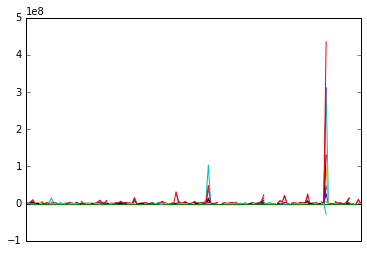

In [18]:
df.loc[:,df.dtypes==np.float].plot(legend=False, xticks=())

Looks like there is a record that is very different that the others... an outlier? Which one is it?

In [19]:
a=(df[df.columns[~df.columns.isin(['email_address'])]] > 3e8).any(1)
df[a]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,...,83925000.0,NaN,42667589.0,NaN,0.0,1398517.0,-27992891.0,48521928.0,NaN,NaN


Sort the columns according to the number of NaN values in them?

In [20]:
df.isnull().sum().sort_values(ascending=False)

loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_poi_to_this_person       60
shared_receipt_with_poi       60
to_messages                   60
from_this_person_to_poi       60
from_messages                 60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
email_address                 35
total_payments                21
total_stock_value             20
poi                            0
dtype: int64

Find out if the values of the non-TOTAL rows sum up correctly to the respective values in the TOTAL row

In [21]:
# Find all columns where the TOTAL row has valid values
col_where_total_is_nan = df.loc['TOTAL', df.loc['TOTAL'].notnull()]
# Also remove the POI column
col_where_total_is_nan.drop('poi', inplace=True)
# Get a view of the original DataFrame containing only the columns that carry a valid value for TOTAL
df_tot_check = df[col_where_total_is_nan.index]
# Check if the non-TOTAL rows sum up correctly to the values in the TOTAL row
a = (df_tot_check.loc[~df.index.isin(['TOTAL'])].sum() == df_tot_check.loc['TOTAL'])
# Print the column names that sum up correctly to the TOTAL
a[a==True]

salary                 True
bonus                  True
loan_advances          True
long_term_incentive    True
dtype: bool

Remove the TOTAL row and the "LOCKHART EUGENE E" row, as well as the email column.

In [22]:
df_cleaned = df.drop(['TOTAL', 'LOCKHART EUGENE E'])
del(df_cleaned['email_address'])
del(df_cleaned['loan_advances'])
del(df_cleaned['director_fees'])
#del(df_cleaned['restricted_stock_deferred'])

In [23]:
print "Number of records belonging to POI=0 class: ", df_cleaned.poi[df_cleaned.poi == 0].size
print "Number of records belonging to POI=1 class: ", df_cleaned.poi[df_cleaned.poi == 1].size

Number of records belonging to POI=0 class:  126
Number of records belonging to POI=1 class:  18


In [24]:
df_cleaned.shape

(144, 18)

## Creating new features

In [25]:
#email_cols = ['from_this_person_to_poi', 'from_this_person_to_poi', 'from_messages', 'to_messages', 'poi']
#total_cols = ['total_payments', 'total_stock_value', 'deferred_income']
#axis_to_drop = np.concatenate((email_cols, total_cols))
df_cleaned['total_gains'] = df_cleaned['total_stock_value'] + df_cleaned['total_payments']
df_cleaned['from_poi_messages_ratio'] = df_cleaned['from_poi_to_this_person'] / df_cleaned['to_messages']
df_cleaned['shared_poi_messages_ratio'] = df_cleaned['shared_receipt_with_poi'] / df_cleaned['to_messages']
#print axis_to_drop
#df_cleaned['TOTALS'] = df.loc[:,~df.columns.isin(email_cols)].sum(axis=1,skipna=True)
#del(df_cleaned['total_payments'])
#del(df_cleaned['total_stock_value'])
#df_cleaned.loc['BADUM JAMES P']
print df_cleaned['from_poi_messages_ratio']

ALLEN PHILLIP K                  0.016196
BADUM JAMES P                         NaN
BANNANTINE JAMES M               0.068905
BAXTER JOHN C                         NaN
BAY FRANKLIN R                        NaN
BAZELIDES PHILIP J                    NaN
BECK SALLY W                     0.019686
BELDEN TIMOTHY N                 0.028532
BELFER ROBERT                         NaN
BERBERIAN DAVID                       NaN
BERGSIEKER RICHARD P             0.010444
BHATNAGAR SANJAY                 0.000000
BIBI PHILIPPE A                  0.014312
BLACHMAN JEREMY M                0.010101
BLAKE JR. NORMAN P                    NaN
BOWEN JR RAYMOND M               0.075350
BROWN MICHAEL                    0.008748
BUCHANAN HAROLD G                0.000000
BUTTS ROBERT H                        NaN
BUY RICHARD B                    0.044280
CALGER CHRISTOPHER F             0.076597
CARTER REBECCA C                 0.092949
CAUSEY RICHARD A                 0.030655
CHAN RONNIE                       

Separating the cleaned input dataset into features and labels

In [26]:
X, y = df_cleaned.loc[:,~df_cleaned.columns.isin(['poi'])], df_cleaned.poi.values.astype(np.int)
names = df_cleaned.index.values
feature_names = X.columns
X = X.values
print X.shape, y.shape
print feature_names

(144, 20) (144,)
Index([u'salary', u'to_messages', u'deferral_payments', u'total_payments',
       u'exercised_stock_options', u'bonus', u'restricted_stock',
       u'shared_receipt_with_poi', u'restricted_stock_deferred',
       u'total_stock_value', u'expenses', u'from_messages', u'other',
       u'from_this_person_to_poi', u'deferred_income', u'long_term_incentive',
       u'from_poi_to_this_person', u'total_gains', u'from_poi_messages_ratio',
       u'shared_poi_messages_ratio'],
      dtype='object')


# Machine Learning

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA, KernelPCA
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.learning_curve import validation_curve
import pydot

Couldn't import dot_parser, loading of dot files will not be possible.


## Imputing missing data

In [28]:
imputer = Imputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y = y.ravel()
print X_imputed.shape, y.shape

(144, 20) (144,)


## >>>>> Sandbox playground <<<<<<<<

Choosing best features

In [29]:
selector = SelectKBest(k=10, score_func=f_classif)
X_kbest = selector.fit_transform(X_imputed, y)
print sorted(zip(selector.scores_, feature_names))
print X_kbest.shape

[(0.096466996044551362, 'restricted_stock_deferred'), (0.1844478897790045, 'from_messages'), (0.26398607335380175, 'deferral_payments'), (0.88638567907732535, 'to_messages'), (1.0242232786527743, 'expenses'), (1.8879886651001847, 'from_poi_messages_ratio'), (2.223561609429177, 'from_this_person_to_poi'), (3.923641446787566, 'other'), (4.2848243476650776, 'from_poi_to_this_person'), (6.6377068002295054, 'shared_poi_messages_ratio'), (7.4779387901614962, 'shared_receipt_with_poi'), (8.4287653667034554, 'total_payments'), (8.4822770639568059, 'restricted_stock'), (8.486577387814604, 'long_term_incentive'), (10.367046503394285, 'deferred_income'), (10.972778462722507, 'salary'), (15.979606683425999, 'bonus'), (16.090988654354295, 'total_gains'), (23.67759272684032, 'total_stock_value'), (27.424868115330316, 'exercised_stock_options')]
(144, 10)


Experimenting with LogisticRegression - comparing use of the full feature space vs the KBest-selected one

In [30]:
n_jobs = 1
scoring = 'recall'
clf = LogisticRegression(penalty='l1', random_state=123)
X_kbest_scaled = StandardScaler().fit_transform(X_kbest)
X_imputed_scaled = StandardScaler().fit_transform(X_imputed)
print "LogReg on KBest-selected features: ", cross_val_score(clf, X_kbest, y, n_jobs=n_jobs, scoring=scoring).mean()
print "LogReg on all features: ", cross_val_score(clf, X_imputed, y, n_jobs=n_jobs, scoring=scoring).mean()
print "LogReg on KBest-selected features, StdScale'd: ",cross_val_score(clf, X_kbest_scaled, y, n_jobs=n_jobs, scoring=scoring).mean()
print "LogReg on all features, StdScale'd: ", cross_val_score(clf, X_imputed_scaled, y, n_jobs=n_jobs, scoring=scoring).mean()
print "LogReg on all features, StdScale'd: ", cross_val_score(clf, X_imputed, y, cv = StratifiedKFold(y,n_folds=5),n_jobs=n_jobs, scoring=scoring).mean()

LogReg on KBest-selected features:  0.166666666667
LogReg on all features:  0.333333333333
LogReg on KBest-selected features, StdScale'd:  0.222222222222
LogReg on all features, StdScale'd:  0.166666666667
LogReg on all features, StdScale'd:  0.3


Reducing dimensionality via PCA

In [31]:
pca = KernelPCA(n_components=2, kernel='rbf', gamma=100)
print X_imputed_scaled.shape
X_imputed_scaled_pca = pca.fit_transform(X_imputed_scaled, y)
X_kbest_scaled_pca = pca.fit_transform(X_kbest_scaled, y)
print X_imputed_scaled_pca.shape
#print pca.explained_variance_ratio_
print "LogReg on PCA-2 features: ", cross_val_score(clf, X_imputed_scaled_pca, y, n_jobs=n_jobs).mean()
print "LogReg on PCA-2 features: ", cross_val_score(clf, X_kbest_scaled_pca, y, n_jobs=n_jobs).mean()

(144, 20)
(144, 2)
LogReg on PCA-2 features:  0.875
LogReg on PCA-2 features:  0.875


Plotting PCA-reduced feature space

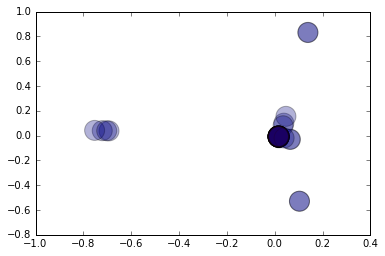

In [32]:
#print X_imputed_scaled_pca
pca1 = X_imputed_scaled_pca.take(0, axis=1)
pca2 = X_imputed_scaled_pca.take(1, axis=1)
#print pca1
plt.scatter(pca1, pca2, c=y*40, s=(y+10)*40, alpha = 0.3)

Trying a RandomForest

In [33]:
clf1 = RandomForestClassifier(n_estimators=30, random_state=123)
print cross_val_score(clf1, X_imputed_scaled_pca, y, scoring='recall').mean()

0.0


Trying kernel SVM

In [34]:
clf2 = SVC(random_state=23, kernel='rbf', C=0.1, gamma=0.1)
clf2.fit(X_kbest_scaled_pca, y)
print cross_val_score(clf2, X_kbest_scaled_pca, y, scoring='recall').mean()

0.0


In [35]:
# Clean playground
del clf, clf1, clf2
del pca1, pca2
del X_kbest_scaled, X_kbest_scaled_pca
del X_imputed_scaled, X_imputed_scaled_pca
del selector
del X_kbest

## >>>>> End of Sandbox playground <<<<<<<<

## Defining useful functions

In [36]:
def plot_roc_curve(clf, clf_name, fname):
    """Plot a ROC (Receiver Operating Characteristic) curve.
    
    Code based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.htm.
    """
    #cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=42)
    cv = StratifiedShuffleSplit(y, n_iter=1000, random_state=42)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    for train, test in cv:
        probs = clf.fit(X_imputed[train], y[train]).predict_proba(X_imputed[test])
        fpr, tpr, thr = roc_curve(y[test], probs[:,1])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)    
    plt.plot([0,1], [0,1], 'g--', label='Luck')
    plt.title('ROC curve for the {}'.format(clf_name))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(fname, dpi=200, format='eps', bbox_inches='tight')
    plt.show()

In [37]:
def plot_clf(clf, clf_name, X, y):
    """
    Plot the decision space of a classifier.
    
    Code borrowed from http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html.
    
    Important: classifier must be a pipeline containing all necessary feature selection & preprocessing.
    """
    h = 0.02 # mesh grid resolution
    from matplotlib.colors import ListedColormap
    
    # Get PCA components
    pca = clf.named_steps['pca']
    x_pca = pca.components_
    
    x_min, x_max = x_pca[0].min() - 0.05, x_pca[0].max() + 0.05
    y_min, y_max = x_pca[1].min() - 0.05, x_pca[1].max() + 0.05
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

    clf_ = clf.named_steps[clf_name]

    
    if hasattr(clf_, 'decision_function'):
        print np.c_[xx.ravel(), yy.ravel()].shape
        Z = clf_.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf_.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
        
    fig = plt.figure()
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cm=cm, alpha=0.8)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.show()    

In [38]:
def print_clf_scores(clf, n_iter=1000):
    ccv = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=0.1, random_state=42)
    print "Recall:    ", cross_val_score(clf, X_imputed, y, cv=ccv, scoring='recall').mean()
    print "Precision: ", cross_val_score(clf, X_imputed, y, cv=ccv, scoring='precision').mean()
    print "F1 score:  ", cross_val_score(clf, X_imputed, y, cv=ccv, scoring='f1').mean()
    print "Accuracy:  ", cross_val_score(clf, X_imputed, y, cv=ccv, scoring='accuracy').mean()
    print "ROC_AUC:   ", cross_val_score(clf, X_imputed, y, cv=ccv, scoring='roc_auc').mean()

In [39]:
def print_confusion_matrix(y, y_pred): 
    cfmx = confusion_matrix(y, y_pred, labels=[1,0])
    tpr = cfmx[0,0]
    fpr = cfmx[1,0]
    tnr = cfmx[1,1]
    fnr = cfmx[0,1]
    print cfmx
    print "tpr: %d, fpr (type I, false alarm): %d, tnr: %d, fnr (type II, miss): %d" % (tpr, fpr, tnr, fnr)
    print "recall:    %.3f" % ((tpr + 0.0) / (tpr+fnr+ 0.0))
    print "precision: %.3f" % ((tpr + 0.0) / (tpr+fpr))
    print "accuracy:  %.3f" % ((tpr + tnr + 0.0) / (cfmx.sum()))

Setting variables common for all experiments below

In [40]:
n_jobs = -1 # Set to -1 to use all CPU, must be set unfortunatel to 1 under cygwin
scoring = 'recall' # Better adapter to unbalanced feature classes

## Logistic Regression (pipelined)

In [41]:
print X_imputed.shape

(144, 20)


In [42]:
warnings.filterwarnings('ignore')

clf = Pipeline([#('poly', PolynomialFeatures(include_bias=False,interaction_only=True)),
                ('kbest', SelectKBest()), 
                ('scaler', MinMaxScaler()),
                ('pca', PCA()),
                ('logreg', LogisticRegression(penalty='l2', class_weight='balanced', 
                                              solver='liblinear', random_state=123))])

poly_degree = [1,2]
n_components = [2, 3, 4, 5, 6]
Cs = np.logspace(-4, 2, 4)
k = [14,16,18,'all']

cv = StratifiedShuffleSplit(y, n_iter=50, test_size=0.1, random_state=42)
grid_search = GridSearchCV(clf, dict(#poly__degree=poly_degree, 
                                     pca__n_components=n_components, 
                                     kbest__k=k, logreg__C=Cs), 
                           cv=cv, error_score=0, scoring=scoring, n_jobs=n_jobs)
%timeit -r1 grid_search.fit(X_imputed, y)

1 loop, best of 1: 21.9 s per loop


In [43]:
print "Best score achieved by GridSearch: ", grid_search.best_score_
print "Best parameters found by GridSearch:"
#print "\tPolyFeatures degree: ", grid_search.best_params_['poly__degree']
best_k = grid_search.best_params_['kbest__k']
if best_k == 'all':
    best_k = len(feature_names)
print "\tKBest k: ", best_k
print "\tPCA n_components: ", grid_search.best_params_['pca__n_components']
print "\tLogReg C: ", grid_search.best_params_['logreg__C']
print "Features selected by KBest (with their p-values):"
best_kbest = grid_search.best_estimator_.named_steps['kbest']
sort_idx = best_kbest.pvalues_.argsort()[-best_k:][::-1]
print sort_idx
kbest_pvalues = best_kbest.pvalues_[sort_idx]
kbest_features = feature_names[sort_idx].values
print zip(kbest_features, kbest_pvalues)
grid_search.best_estimator_

Best score achieved by GridSearch:  0.92
Best parameters found by GridSearch:
	KBest k:  20
	PCA n_components:  3
	LogReg C:  0.0001
Features selected by KBest (with their p-values):
[ 8 11  2  1 10 18 13 12 16 19  7  3  6 15 14  0  5 17  9  4]
[('restricted_stock_deferred', 0.75656671426587674), ('from_messages', 0.66822927770707108), ('deferral_payments', 0.60819337946917229), ('to_messages', 0.34805754450626925), ('expenses', 0.31324067142364614), ('from_poi_messages_ratio', 0.17159393558020683), ('from_this_person_to_poi', 0.1381373100133986), ('other', 0.04954358735502426), ('from_poi_to_this_person', 0.040265830762330819), ('shared_poi_messages_ratio', 0.011004905212623605), ('shared_receipt_with_poi', 0.0070421608134275523), ('total_payments', 0.004283744007120031), ('restricted_stock', 0.0041665313025078454), ('long_term_incentive', 0.0041572564806001029), ('deferred_income', 0.0015901528728009566), ('salary', 0.0011728987940247744), ('bonus', 0.0001025063997909007), ('total_ga

Pipeline(steps=[('kbest', SelectKBest(k='all', score_func=<function f_classif at 0x7f9bbff616e0>)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('logreg', LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [44]:
print_clf_scores(grid_search.best_estimator_)

y_pred = grid_search.best_estimator_.predict(X_imputed)
print y_pred - y*2
print recall_score(y,y_pred)
print precision_score(y,y_pred)
print accuracy_score(y,y_pred)
print roc_auc_score(y,y_pred)

Recall:     0.8815
Precision:  0.354078210678
F1 score:   0.493212964813
Accuracy:   0.739666666667
ROC_AUC:    0.831153846154
[ 1  0  0  1  0  0  0 -1  0  0  0  0  1  1  0 -1  0  0  0  1 -1  0 -1  0  0
  0 -1  0  0  0  0 -1  1  0  1  1  0  1  0  0  0  0  1 -1  0  0  0  1  0  0
  0  0  0  0 -1  0  0  0  1 -1  0  0  0  0  0 -1  1  0  1  1  0  0  0  1  0
  1 -1 -2  1 -1  1  0  0  0  0  1  0  1  1  0  1  0  1  0  0  0  0  1  0  0
  0  0  1  0  0  0  0  0  0  1  0 -1 -1  0  0  1  1  1 -2  1  1 -1  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0 -1  0]
0.888888888889
0.313725490196
0.743055555556
0.805555555556


In [45]:
print_confusion_matrix(y, y_pred)

[[16  2]
 [35 91]]
tpr: 16, fpr (type I, false alarm): 35, tnr: 91, fnr (type II, miss): 2
recall:    0.889
precision: 0.314
accuracy:  0.743


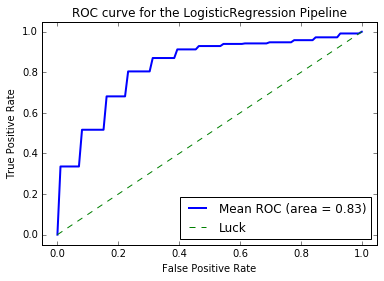

In [46]:
plot_roc_curve(grid_search.best_estimator_, "LogisticRegression Pipeline", "logreg_roc.eps")

## Random Forest (Pipelined)

In [47]:
warnings.filterwarnings('ignore')

clf = Pipeline([#('poly', PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('kbest', SelectKBest()), 
                ('scaler', MinMaxScaler()), 
                ('pca', PCA()), 
                ('rf', RandomForestClassifier(n_estimators=11, n_jobs=n_jobs, 
                                              random_state=123, class_weight='balanced'))])

poly_degree = [1,2]
n_components = [2, 3, 4]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3, 4]
k = [16, 18, 20]

cv = StratifiedShuffleSplit(y, n_iter=50, random_state=42)
grid_search = GridSearchCV(clf, dict(#poly__degree=poly_degree, 
                                     pca__n_components=n_components, 
                                     kbest__k=k, 
                                     rf__min_samples_split=min_samples_split,
                                     rf__min_samples_leaf=min_samples_leaf), 
                           cv=cv, error_score=0, scoring=scoring, n_jobs=n_jobs)
%timeit -r1 grid_search.fit(X_imputed, y)

1 loop, best of 1: 3min 44s per loop


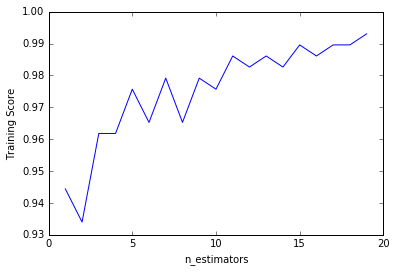

In [48]:
est = np.arange(1,20,1)
train_scores, valid_scores = validation_curve(clf, X_imputed, y, "rf__n_estimators", est)
plt.plot(est, train_scores.mean(axis=1), 'b', label='Training score')
#plt.plot(est, valid_scores.mean(axis=1), 'r', label='Cross-validation score', )
#plt.title("Validation curve for parameter n_estimators of a RandomForestClassifier")
plt.xlabel('n_estimators')
plt.ylabel('Training Score')


In [49]:
print "Best score achieved by GridSearch: ", grid_search.best_score_
print "Best parameters found by GridSearch:"
#print "\tPolyFeatures degree: ", grid_search.best_params_['poly__degree']
print "\tKBest k: ", grid_search.best_params_['kbest__k']
print "\tPCA n_components: ", grid_search.best_params_['pca__n_components']
print "\tRandomForest min_samples_split: ", grid_search.best_params_['rf__min_samples_split']
print "\tRandomForest min_samples_leaf: ", grid_search.best_params_['rf__min_samples_leaf']
print "Features selected by KBest (with their p-values):"
best_kbest = grid_search.best_estimator_.named_steps['kbest']
best_kbest_k = best_kbest.k
sort_idx = best_kbest.pvalues_.argsort()[-best_kbest_k:][::-1]
kbest_pvalues = best_kbest.pvalues_[sort_idx]
kbest_features = feature_names[sort_idx].values
print zip(kbest_features, kbest_pvalues)
grid_search.best_estimator_

Best score achieved by GridSearch:  0.54
Best parameters found by GridSearch:
	KBest k:  18
	PCA n_components:  3
	RandomForest min_samples_split:  2
	RandomForest min_samples_leaf:  4
Features selected by KBest (with their p-values):
[('restricted_stock_deferred', 0.75656671426587674), ('from_messages', 0.66822927770707108), ('deferral_payments', 0.60819337946917229), ('to_messages', 0.34805754450626925), ('expenses', 0.31324067142364614), ('from_poi_messages_ratio', 0.17159393558020683), ('from_this_person_to_poi', 0.1381373100133986), ('other', 0.04954358735502426), ('from_poi_to_this_person', 0.040265830762330819), ('shared_poi_messages_ratio', 0.011004905212623605), ('shared_receipt_with_poi', 0.0070421608134275523), ('total_payments', 0.004283744007120031), ('restricted_stock', 0.0041665313025078454), ('long_term_incentive', 0.0041572564806001029), ('deferred_income', 0.0015901528728009566), ('salary', 0.0011728987940247744), ('bonus', 0.0001025063997909007), ('total_gains', 9.72

Pipeline(steps=[('kbest', SelectKBest(k=18, score_func=<function f_classif at 0x7f9bbff616e0>)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini...imators=11, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False))])

In [50]:
print_clf_scores(grid_search.best_estimator_)

y_pred = grid_search.best_estimator_.predict(X_imputed)
print y_pred - 2*y
print recall_score(y,y_pred)
print precision_score(y,y_pred)
print accuracy_score(y,y_pred)
print roc_auc_score(y,y_pred)

Recall:     0.5
Precision:  0.354476984127
F1 score:   0.388964646465
Accuracy:   0.803666666667
ROC_AUC:    0.791961538462
[ 0  0  0  1  0  0  0 -1  0  0  0  0  0  1  0 -1  0  0  0  0 -1  0 -1  0  0
  0 -1  0  0  0  0 -2  0  0  1  1  0  1  0  0  0  0  0 -1  0  0  0  1  0  0
  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0  1  0
  0 -1 -2  1 -1  1  0  0  0  0  1  0  1  0  0  1  0  0  0  0  0  0  1  0  0
  0  0  1  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  1 -2  0  0 -1  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0 -1  0]
0.833333333333
0.46875
0.861111111111
0.849206349206


In [51]:
print_confusion_matrix(y, y_pred)

[[ 15   3]
 [ 17 109]]
tpr: 15, fpr (type I, false alarm): 17, tnr: 109, fnr (type II, miss): 3
recall:    0.833
precision: 0.469
accuracy:  0.861


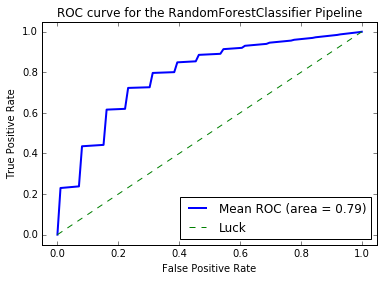

In [52]:
plot_roc_curve(grid_search.best_estimator_, "RandomForestClassifier Pipeline", "rforest_roc.eps")

## Support Vector Machines (SVC - pipelined)

In [53]:
warnings.filterwarnings('ignore')

clf = Pipeline([#('poly', PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('kbest', SelectKBest()), 
                ('scaler', StandardScaler()), 
                ('pca', PCA()), 
                ('svc', SVC(kernel='rbf', random_state=123, class_weight='balanced', probability=True))])

poly_degree = [1,2]
n_components = [2, 3, 4]
Cs = [0.01, 0.1, 1, 10] # np.logspace(-5,2,6)
gamma = ['auto'] #['auto', 0.001, 0.1]
k = [6,8,10,12,14,16]

cv = StratifiedShuffleSplit(y, n_iter=50, random_state=42)
grid_search = GridSearchCV(clf, dict(#poly__degree=poly_degree, 
                                     pca__n_components=n_components, 
                                     kbest__k=k, 
                                     svc__gamma=gamma,
                                     svc__C=Cs), 
                           cv=cv, error_score=0, scoring=scoring, n_jobs=n_jobs)
%timeit -r1 grid_search.fit(X_imputed, y)

1 loop, best of 1: 41.3 s per loop


In [54]:
print "Best score achieved by GridSearch: ", grid_search.best_score_
print "Best parameters found by GridSearch:"
#print "\tPolyFeatures degree: ", grid_search.best_params_['poly__degree']
print "\tKBest k: ", grid_search.best_params_['kbest__k']
print "\tPCA n_components: ", grid_search.best_params_['pca__n_components']
print "\tSVC C: ", grid_search.best_params_['svc__C']
print "\tSVC Gamma: ", grid_search.best_params_['svc__gamma']
print "Features selected by KBest (with their p-values):"
best_kbest = grid_search.best_estimator_.named_steps['kbest']
best_kbest_k = best_kbest.k
sort_idx = best_kbest.pvalues_.argsort()[-best_kbest_k:][::-1]
kbest_pvalues = best_kbest.pvalues_[sort_idx]
kbest_features = feature_names[sort_idx].values
print zip(kbest_features, kbest_pvalues)
grid_search.best_estimator_

Best score achieved by GridSearch:  0.86
Best parameters found by GridSearch:
	KBest k:  14
	PCA n_components:  4
	SVC C:  0.1
	SVC Gamma:  auto
Features selected by KBest (with their p-values):
[('restricted_stock_deferred', 0.75656671426587674), ('from_messages', 0.66822927770707108), ('deferral_payments', 0.60819337946917229), ('to_messages', 0.34805754450626925), ('expenses', 0.31324067142364614), ('from_poi_messages_ratio', 0.17159393558020683), ('from_this_person_to_poi', 0.1381373100133986), ('other', 0.04954358735502426), ('from_poi_to_this_person', 0.040265830762330819), ('shared_poi_messages_ratio', 0.011004905212623605), ('shared_receipt_with_poi', 0.0070421608134275523), ('total_payments', 0.004283744007120031), ('restricted_stock', 0.0041665313025078454), ('long_term_incentive', 0.0041572564806001029)]


Pipeline(steps=[('kbest', SelectKBest(k=14, score_func=<function f_classif at 0x7f9bbff616e0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=4, whiten=False)), ('svc', SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=123, shrinking=True,
  tol=0.001, verbose=False))])

In [55]:
print_clf_scores(grid_search.best_estimator_)

y_pred = grid_search.best_estimator_.predict(X_imputed)
print y_pred -2*y
print recall_score(y, y_pred)
print precision_score(y, y_pred)
print accuracy_score(y, y_pred)
print roc_auc_score(y, y_pred)

Recall:     0.817
Precision:  0.332728391053
F1 score:   0.461329353979
Accuracy:   0.730933333333
ROC_AUC:    0.772057692308
[ 1  0  0  1  0  0  1 -1  0  0  0  0  0  1  0 -1  0  0  0  1 -1  0 -1  0  0
  0 -1  0  0  0  0 -1  1  0  1  1  0  1  0  0  0  0  1 -1  0  0  0  1  0  0
  0  0  0  0 -1  0  0  0  1 -1  0  0  0  0  0 -1  0  0  0  1  0  0  1  1  0
  1 -1 -2  1 -1  1  0  0  0  0  1  0  1  1  0  1  0  0  0  0  0  0  1  0  0
  0  0  1  0  0  0  0  0  0  1  0 -1 -1  0  0  1  1  1 -2  0  1 -1  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0 -1  0]
0.888888888889
0.333333333333
0.763888888889
0.81746031746


In [56]:
print_confusion_matrix(y, y_pred)

[[16  2]
 [32 94]]
tpr: 16, fpr (type I, false alarm): 32, tnr: 94, fnr (type II, miss): 2
recall:    0.889
precision: 0.333
accuracy:  0.764


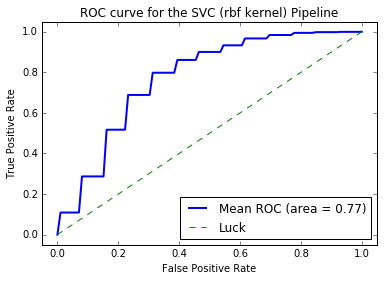

In [57]:
plot_roc_curve(grid_search.best_estimator_, "SVC (rbf kernel) Pipeline", "svc_roc.eps")

##### Appendix: See how "final_project_dataset_modified.pkl" is different from "final_project_dataset.pkl"

In [58]:
dm = pickle.load(open("final_project_dataset_modified.pkl"))
do = d

In [59]:
len(dm)

143

In [60]:
set(do.keys())-set(dm.keys())

{'LAY KENNETH L', 'SKILLING JEFFREY K', 'TOTAL'}

In [61]:
len(dm[dm.keys()[0]])

21

In [62]:
do.pop('LAY KENNETH L',"")
do.pop('SKILLING JEFFREY K',"")
do.pop('TOTAL',"")

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [63]:
len(do)

143

In [64]:
do==dm

False

In [65]:
set(do.keys())==set(dm.keys())

True

In [66]:
set(dm[dm.keys()[0]].keys())-set(do[do.keys()[0]].keys())

set()

In [67]:
for k in do.keys():
    if do[k] != dm[k]:
        print k

BHATNAGAR SANJAY


##### Appendix 2: Miscellaneous experiments

In [68]:
from sklearn.cross_validation import KFold, StratifiedKFold

In [69]:
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,1])
skf = StratifiedKFold(labels, random_state=123)
for train, test in skf:
    print("%s %s" % (labels[train], test))

[0 0 0 0 0 0 0 1 1] [ 0  1  2  3 11]
[0 0 0 0 0 0 0 1 1] [ 4  5  6  7 12]
[0 0 0 0 0 0 0 0 1 1] [ 8  9 10 13]


In [70]:
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,1])
skf = KFold(10, random_state=123)
for train, test in skf:
    print("%s %s" % (train, test))

[4 5 6 7 8 9] [0 1 2 3]
[0 1 2 3 7 8 9] [4 5 6]
[0 1 2 3 4 5 6] [7 8 9]


In [71]:
df.to_dict('index')

{'ALLEN PHILLIP K': {'bonus': 4175000.0,
  'deferral_payments': 2869717.0,
  'deferred_income': -3081055.0,
  'director_fees': nan,
  'email_address': 'phillip.allen@enron.com',
  'exercised_stock_options': 1729541.0,
  'expenses': 13868.0,
  'from_messages': 2195.0,
  'from_poi_to_this_person': 47.0,
  'from_this_person_to_poi': 65.0,
  'loan_advances': nan,
  'long_term_incentive': 304805.0,
  'other': 152.0,
  'poi': 0.0,
  'restricted_stock': 126027.0,
  'restricted_stock_deferred': -126027.0,
  'salary': 201955.0,
  'shared_receipt_with_poi': 1407.0,
  'to_messages': 2902.0,
  'total_payments': 4484442.0,
  'total_stock_value': 1729541.0},
 'BADUM JAMES P': {'bonus': nan,
  'deferral_payments': 178980.0,
  'deferred_income': nan,
  'director_fees': nan,
  'email_address': nan,
  'exercised_stock_options': 257817.0,
  'expenses': 3486.0,
  'from_messages': nan,
  'from_poi_to_this_person': nan,
  'from_this_person_to_poi': nan,
  'loan_advances': nan,
  'long_term_incentive': nan,
